In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

Mounted at /content/gdrive


In [2]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  !git clone https://github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

Cloning into 'radiology_ai'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 548 (delta 7), reused 5 (delta 2), pack-reused 532
Receiving objects: 100% (548/548), 51.24 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (338/338), done.
/content/radiology_ai


In [3]:
#@title Setup environment and Colab general variables { display-mode: "form" }
%%capture
%run colab_setup.ipynb

In [4]:
#@title Move images from Drive to temporary folder here to be able to train models { display-mode: "form" }
%%capture
%run move_raw_preprocess.ipynb

In [7]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from fastai.basics import *
from fastai.callback.all import *
from fastai.data.block import *
from fastai.data.transforms import *
from fastai.vision import models
from fastai.vision.augment import *
from fastai.vision.core import PILImageBW
from fastai.vision.data import *
from fastai.vision.learner import create_cnn_model

from efficientnet_pytorch import EfficientNet

In [8]:
from semisupervised.mixmatch.losses import MixMatchLoss
from semisupervised.mixmatch.callback import MixMatchCallback
from semisupervised.utils import TestColSplitter
from semisupervised.ema import EMAModel

# Required to load DICOM on the fly
from preprocessing import PILDicom_scaled, init_bins, HistScaled

from utils import seed_everything, concat_templates

In [9]:
df = concat_templates(organize_folder, excel=True)
df.to_excel(
    os.path.join(PATH_PREFIX, 'all.xlsx'),
    index=False
)
# df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})

In [10]:
TEST_SIZE = 0.15
VALID_SIZE = 0.15

In [11]:
# Hyperparameters

HIST_SCALED = False
HIST_SCALED_SELF = True

LR = 0.002

BATCH_SIZE = 16
RESIZE = 512
RANDOM_RESIZE_CROP = 256

T = 0.5
LAMBDA_U = 75
ALPHA = 0.75
EMA_DECAY = 0.999

# MODEL = models.resnet18
MODEL = 'efficientnet-b0'

In [14]:
SEED = 42

seed_everything(SEED)

Using seed: 42


42

In [15]:
# Transformations

item_tfms = [
    Resize(RESIZE, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    # RandomResizedCrop(RANDOM_RESIZE_CROP),
]

label_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    # Normalize()
]

class Multiply_255(Transform):
    def encodes(self, o): return o * 255

unlabel_transform = [
    RandomResizedCropGPU(RANDOM_RESIZE_CROP),
    Flip(),
    Rotate(180, p=1),
    # Multiply_255(),
    # Normalize()
]

In [16]:
# Callbacks
from fastai.callback.tensorboard import TensorBoardCallback

cbs = None
cbs = [TensorBoardCallback()]
# cbs = []

In [17]:
# Data
df = pd.read_excel(os.path.join(PATH_PREFIX, 'all.xlsx'), dtype={'ID':'string','Target':'string'})

relation_df = pd.read_csv(os.path.join(PATH_PREFIX, 'relation.csv'))
relation_df = relation_df.set_index('Filename')

final_df = df.set_index('ID').merge(relation_df, left_index=True, right_index=True)
final_df['ID'] = final_df.index.values
final_df = final_df.reset_index(drop=True)
final_df['Raw_preprocess'] = final_df['Original_Filename'].apply(lambda filename: os.path.join(raw_preprocess_folder, filename + '.png'))

unlabel_df = final_df[df['Target'].isnull()].reset_index(drop=True)
label_df = final_df[df['Target'].notnull()].reset_index(drop=True)

try:
  train_df, test_df = train_test_split(label_df, test_size=TEST_SIZE, shuffle=True, stratify=label_df['Target'], random_state=SEED)
except ValueError:
  train_df, test_df = train_test_split(label_df, test_size=TEST_SIZE, shuffle=True, random_state=SEED)

try:
  train_df, val_df = train_test_split(train_df, test_size=VALID_SIZE/(1-TEST_SIZE), shuffle=True, stratify=train_df['Target'], random_state=SEED)
except ValueError:
  train_df, val_df = train_test_split(train_df, test_size=VALID_SIZE/(1-TEST_SIZE), shuffle=True, random_state=SEED)

label_df.loc[train_df.index, 'Dataset'] = 'train'
label_df.loc[val_df.index, 'Dataset'] = 'valid'
label_df.loc[test_df.index, 'Dataset'] = 'test'

In [18]:
# Histogram scaling DICOM on the fly

if HIST_SCALED:
    if HIST_SCALED_SELF:
        bins = None
    else:
        # bins = init_bins(fnames=L(list(final_df['Original'].values)), n_samples=100)
        bins = init_bins(fnames=L(list(final_df['Raw_preprocess'].values)), n_samples=100, isDCM=False)
    # item_tfms.append(HistScaled(bins))
    item_tfms.append(HistScaled_all(bins))

In [19]:
# DataLoaders
print(f'==> Preparing label dataloaders')

label_dl = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), MultiCategoryBlock),
    get_x=ColReader('Original_Filename', pref=raw_preprocess_folder+'/', suff='.png'), 
    # blocks=(ImageBlock(cls=PILDicom_scaled), MultiCategoryBlock),
    # get_x=ColReader('Original'),
    get_y=ColReader('Target'),
    splitter=TestColSplitter(col='Dataset'),
    item_tfms=item_tfms,
    batch_tfms=label_transform,
).dataloaders(label_df, bs=BATCH_SIZE, num_workers=0, shuffle_train=True, drop_last=True)

print(f'==> Preparing unlabel dataloaders')

ds_params = {
    'blocks': (ImageBlock(cls=PILImageBW)),
    'get_x': ColReader('Original_Filename', pref=raw_preprocess_folder+'/', suff='.png'),
    # 'blocks': (ImageBlock(cls=PILDicom_scaled)),
    # 'get_x': ColReader('Original'),
    'splitter': RandomSplitter(0),
    'item_tfms': item_tfms
}
dls_params = {
    'source': unlabel_df,
    'bs': BATCH_SIZE,
    'num_workers': 0,
    'shuffle_train': True,
    'drop_last': True
}

unlabel_dl = DataBlock(
    **ds_params
).dataloaders(**dls_params)

transform_dl = DataBlock(
    **ds_params,
    batch_tfms = unlabel_transform
).dataloaders(**dls_params)

print(f'==> Preparing MixMatch callback')

if cbs is None:
    cbs = [MixUp(ALPHA)]
else:
    cbs.append(MixUp(ALPHA))

cbs.append(MixMatchCallback(unlabel_dl, transform_dl, T))

==> Preparing label dataloaders
==> Preparing unlabel dataloaders
==> Preparing MixMatch callback


In [20]:
# Model
print("==> creating model")

def create_model(model_arq, n_out, model=None, pretrained=True, n_in=1, ema=False):
    if model is None:
      if model_arq[:12].lower() == 'efficientnet':
        model = EfficientNet.from_pretrained(model_arq, num_classes=n_out, include_top=True, in_channels=n_in)
      else:
        model = create_cnn_model(model_arq, n_out=n_out, cut=None, pretrained=pretrained, n_in=n_in)
    
    if torch.cuda.is_available():
      model = model.cuda()

    if ema:
        for param in model.parameters():
            param.detach_()

    return model

classes = label_df['Target'].unique()
n_out = len(classes)

model = create_model(MODEL, n_out, pretrained=True, n_in=1)

cbs.append(EMAModel(alpha=EMA_DECAY))

==> creating model


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [21]:
# Loss
print("==> defining loss")

class_weight = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['Target'])
class_weight = torch.as_tensor(class_weight).float()
if torch.cuda.is_available():
    class_weight = class_weight.cuda()

train_criterion = MixMatchLoss(unlabel_dl=unlabel_dl, model=model, n_out=n_out, bs=BATCH_SIZE, lambda_u=LAMBDA_U, weight=class_weight)
criterion = train_criterion.Lx_criterion

==> defining loss


In [23]:
# Learner
print("==> defining learner")

Lx_metric = AvgMetric(func=criterion)
Lu_metric = AvgMetric(func=train_criterion.Lu_criterion)

f1_score = F1ScoreMulti(average='macro')
precision = PrecisionMulti(average='macro')
recall = RecallMulti(average='macro')
fastai_metrics = [
    # Lx_metric, Lu_metric, 
    f1_score,
    precision, recall
]

learn = Learner(label_dl, model, loss_func=train_criterion, lr=LR, metrics=fastai_metrics, cbs=cbs)

==> defining learner


SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=0.033113110810518265)

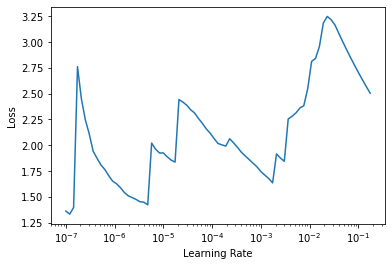

In [26]:
learn.freeze()
learn.lr_find()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.019054606556892395)

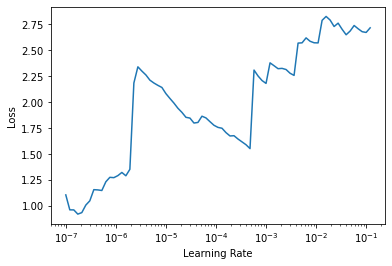

In [27]:
learn.unfreeze()
learn.lr_find()

In [28]:
learn.fine_tune(15, 0.03, freeze_epochs=3)

epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,time
0,0.961785,0.002993,0.333333,0.333333,0.333333,00:16
1,13.744245,0.000483,0.333333,0.333333,0.333333,00:16
2,21.264709,0.000086,0.333333,0.333333,0.333333,00:16


/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch,train_loss,valid_loss,f1_score,precision_score,recall_score,time
0,31.615101,0.000056,0.333333,0.333333,0.333333,00:16
1,17.705252,0.005677,0.333333,0.333333,0.333333,00:16
2,19.117393,0.043007,0.313008,0.333333,0.295019,00:16
3,17.363420,15.280303,0.000000,0.000000,0.000000,00:16
4,16.545715,160.805115,0.000000,0.000000,0.000000,00:16
5,25.374466,127.521645,0.074830,0.333333,0.042146,00:16
6,22.087072,0.000000,0.333333,0.333333,0.333333,00:16
7,42.155720,0.000000,0.333333,0.333333,0.333333,00:16
8,28.588945,0.000000,0.333333,0.333333,0.333333,00:16
9,24.903162,1193024256.000000,0.333333,0.333333,0.333333,00:16


KeyboardInterrupt: ignored